In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
torch.manual_seed(42)
import matplotlib.pyplot as plt
from PIL import Image
import skimage
np.random.seed(42)
torch.manual_seed(42)

In [2]:
class relu_mlp(nn.Module):
  def __init__(self, neurons, h_layers):
    super(relu_mlp, self).__init__()
    self.neurons = neurons
    self.h_layers = h_layers

    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(2,neurons))
    for i in range (h_layers-1):
      self.layers.append(nn.Linear(neurons,neurons))
    self.layers.append(nn.Linear(neurons, 3))
  
  def forward (self,x):
    for layer in self.layers[:-1]:
      x = F.relu(layer(x))
    x = self.layers[-1](x)
    return x

In [3]:
class siren_mlp(nn.Module):
  def __init__(self, neurons, h_layers, omega):
    super(siren_mlp, self).__init__()
    self.neurons = neurons
    self.h_layers = h_layers
    self.omega = omega

    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(2, neurons))
    for i in range(h_layers-1):
      self.layers.append(nn.Linear(neurons, neurons))
    self.layers.append(nn.Linear(neurons,3))

    nn.init.uniform_(self.layers[0].weight,-1/2,1/2)
    for layer in self.layers[1:]:
      nn.init.uniform_(layer.weight,-np.sqrt(6/neurons)/omega, np.sqrt(6/neurons)/omega)
  
  def forward (self, x):
    for layer in self.layers[:-1]:
      x = torch.sin(layer(x))
    x = self.layers[-1](x)
    return x

In [4]:
def coordinates (n):
  # Create an empty list to store the tuples
  tuples = []

  # Iterate over all x and y values from 0 to 512
  for x in range(n):
      for y in range(n):
          # Append the current tuple to the list
          tuples.append([x, y])

  # Convert the list to a NumPy array if desired
  tuples_array = np.array(tuples)
  return tuples_array

In [5]:
%cd --

/content


In [6]:
import os
os.chdir("/content/drive/MyDrive")

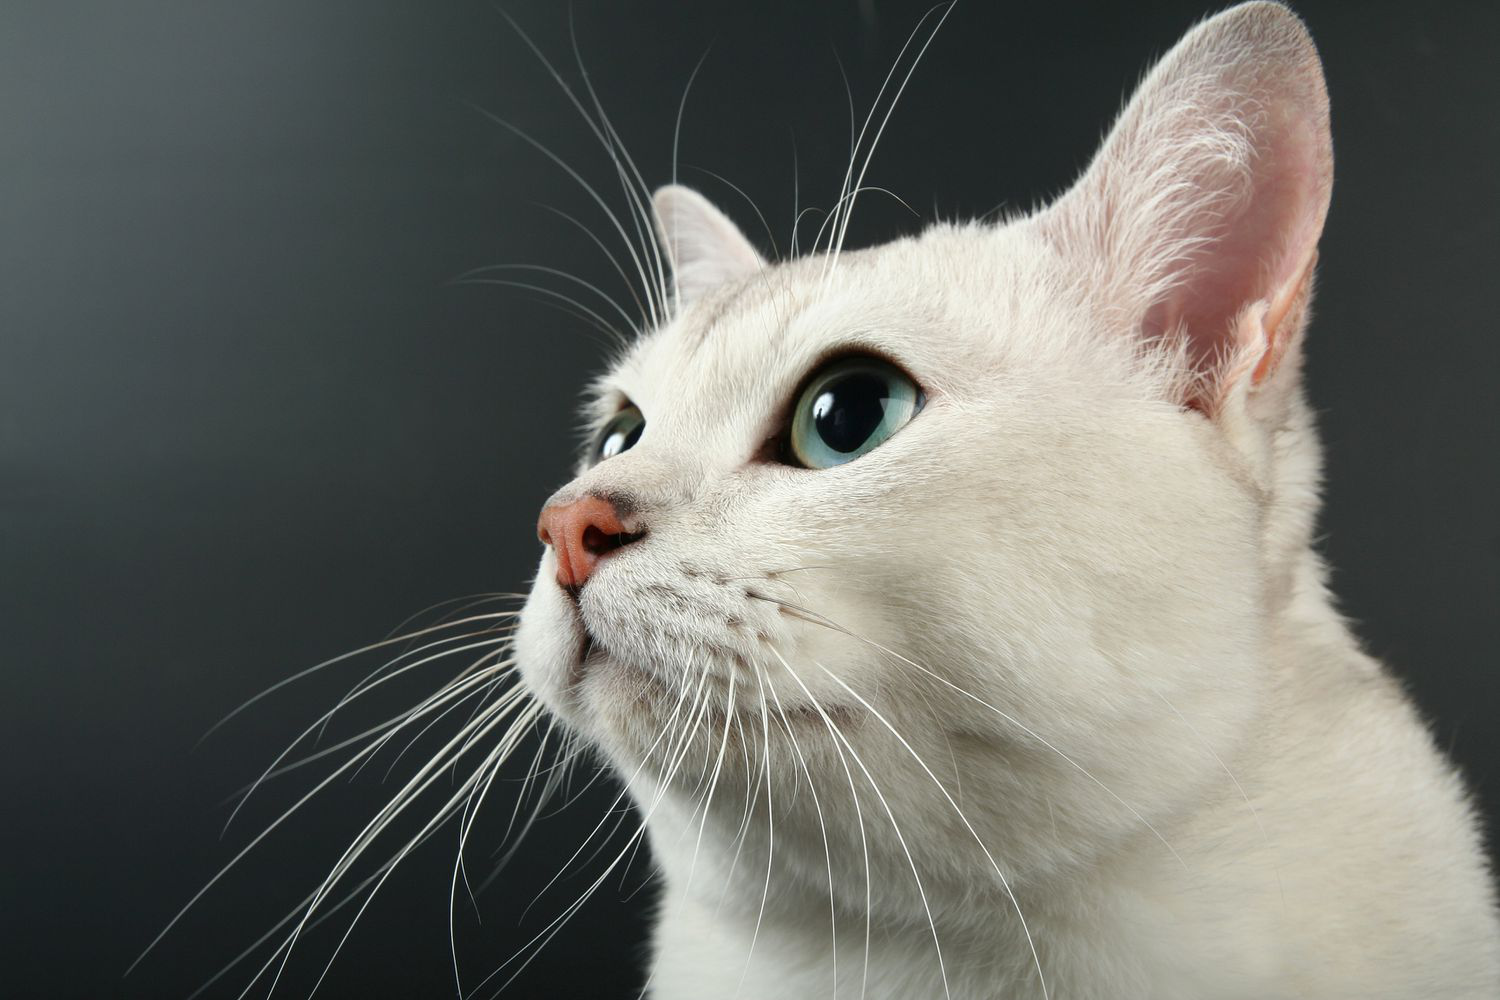

In [7]:
from PIL import Image

img = Image.open('cat.jpeg')
img.show()

In [8]:
img.size

(1500, 1000)

In [9]:
img = img.resize((256,256))

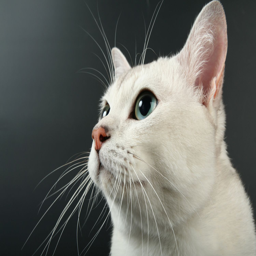

In [10]:
img

In [11]:
image_array = np.array(img)

In [12]:
image_array

array([[[ 88, 100, 100],
        [ 88, 100, 100],
        [ 88, 100, 100],
        ...,
        [ 40,  46,  44],
        [ 40,  46,  44],
        [ 41,  47,  45]],

       [[ 88, 100, 100],
        [ 88, 100, 100],
        [ 88, 100, 100],
        ...,
        [ 40,  46,  44],
        [ 40,  46,  44],
        [ 41,  47,  45]],

       [[ 89, 101, 101],
        [ 89, 101, 101],
        [ 88, 100, 100],
        ...,
        [ 42,  48,  46],
        [ 41,  47,  45],
        [ 41,  47,  45]],

       ...,

       [[ 21,  27,  27],
        [ 20,  26,  26],
        [ 21,  26,  26],
        ...,
        [170, 170, 158],
        [172, 172, 162],
        [167, 167, 157]],

       [[ 20,  27,  26],
        [ 20,  25,  26],
        [ 21,  24,  25],
        ...,
        [173, 173, 161],
        [168, 168, 158],
        [162, 164, 153]],

       [[ 18,  26,  25],
        [ 19,  24,  25],
        [ 20,  23,  24],
        ...,
        [175, 175, 163],
        [171, 172, 161],
        [167, 169, 158]]

In [13]:
image_array.shape

(256, 256, 3)

In [14]:
X = coordinates(256)
X

array([[  0,   0],
       [  0,   1],
       [  0,   2],
       ...,
       [255, 253],
       [255, 254],
       [255, 255]])

In [15]:
len(X)

65536

In [16]:
y = []
for x in X:
  vectors = [image_array[x[0]][x[1]][i] for i in range(3)]
  y.append(vectors)

In [17]:
len(y)

65536

In [18]:
y = np.array(y)

In [19]:
from tqdm import tqdm

In [20]:
device = 'cuda'

In [ ]:
relu_model = relu_mlp(256,4).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(relu_model.parameters(), lr=0.0001)

In [ ]:
a = torch.tensor([[1,1], [0,0]], dtype=torch.float32)
b = torch.tensor([[3,4], [1,1]], dtype=torch.float32)
criterion(a,b)

tensor(3.7500)

In [ ]:
relu_psnr = []

In [ ]:
num_epochs = 1000
for e in tqdm(range(num_epochs)):
  y_pred_train = relu_model(torch.from_numpy(X.astype('float32')).to(device)).squeeze()
  loss = criterion(y_pred_train, torch.from_numpy(y.astype('float32')).to(device)) # loss is a tensor which stores the current value of train loss
  relu_psnr.append(20 * np.log10(1.0 / np.sqrt(loss.item())))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 100 == 0:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss
  if e == num_epochs-1:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss

  0%|          | 4/1000 [00:00<00:34, 29.09it/s]

Epoch [0/1000], Loss: 683.7406


 11%|█         | 107/1000 [00:03<00:24, 36.08it/s]

Epoch [100/1000], Loss: 680.4171


 21%|██        | 207/1000 [00:05<00:22, 35.80it/s]

Epoch [200/1000], Loss: 665.8541


 31%|███       | 307/1000 [00:08<00:19, 35.52it/s]

Epoch [300/1000], Loss: 726.1296


 41%|████      | 407/1000 [00:11<00:16, 35.23it/s]

Epoch [400/1000], Loss: 714.4355


 51%|█████     | 507/1000 [00:14<00:13, 35.29it/s]

Epoch [500/1000], Loss: 680.7737


 61%|██████    | 607/1000 [00:17<00:11, 35.07it/s]

Epoch [600/1000], Loss: 659.3785


 71%|███████   | 707/1000 [00:20<00:08, 34.85it/s]

Epoch [700/1000], Loss: 678.1626


 81%|████████  | 807/1000 [00:22<00:05, 34.60it/s]

Epoch [800/1000], Loss: 697.3358


 91%|█████████ | 907/1000 [00:25<00:02, 34.59it/s]

Epoch [900/1000], Loss: 656.4387


100%|██████████| 1000/1000 [00:28<00:00, 35.09it/s]

Epoch [999/1000], Loss: 709.0409


In [ ]:
len(relu_psnr)

15000

In [ ]:
y_preds = relu_model(torch.from_numpy(X.astype('float32')).to(device))

In [ ]:
y_preds.shape

torch.Size([65536, 3])

In [ ]:
X

array([[  0,   0],
       [  0,   1],
       [  0,   2],
       ...,
       [255, 253],
       [255, 254],
       [255, 255]])

In [ ]:
X.shape

(65536, 2)

In [ ]:
image_array

array([[[ 89, 101, 101],
        [ 88, 100, 100],
        [ 88, 100, 100],
        ...,
        [ 40,  46,  44],
        [ 40,  46,  44],
        [ 41,  47,  45]],

       [[ 88, 100, 100],
        [ 88, 100, 100],
        [ 88, 100, 100],
        ...,
        [ 40,  46,  44],
        [ 40,  46,  44],
        [ 41,  47,  45]],

       [[ 89, 101, 101],
        [ 89, 101, 101],
        [ 88, 100, 100],
        ...,
        [ 42,  48,  46],
        [ 41,  47,  45],
        [ 41,  47,  45]],

       ...,

       [[ 21,  27,  27],
        [ 20,  26,  26],
        [ 21,  27,  27],
        ...,
        [170, 170, 158],
        [171, 171, 162],
        [166, 167, 156]],

       [[ 19,  27,  26],
        [ 20,  25,  26],
        [ 21,  24,  25],
        ...,
        [173, 173, 161],
        [169, 169, 159],
        [162, 164, 153]],

       [[ 18,  26,  25],
        [ 19,  24,  25],
        [ 20,  23,  25],
        ...,
        [175, 175, 163],
        [172, 172, 162],
        [167, 169, 158]]

In [ ]:
image_array.shape

(256, 256, 3)

In [ ]:
vals  = y_preds.cpu().detach().numpy().reshape(256,256,3).astype('uint8')

In [ ]:
vals

array([[[ 89, 101, 101],
        [ 88, 100, 100],
        [ 88, 100, 100],
        ...,
        [ 26,  33,  31],
        [ 25,  32,  30],
        [ 24,  31,  30]],

       [[ 88, 100, 100],
        [ 88, 100, 100],
        [ 88, 100, 100],
        ...,
        [ 26,  33,  32],
        [ 25,  33,  31],
        [ 24,  32,  30]],

       [[ 89, 101, 101],
        [ 89, 100, 101],
        [ 89, 100, 101],
        ...,
        [ 27,  34,  33],
        [ 26,  33,  32],
        [ 25,  33,  31]],

       ...,

       [[ 23,  30,  32],
        [ 23,  30,  32],
        [ 23,  29,  31],
        ...,
        [196, 194, 177],
        [197, 195, 177],
        [197, 195, 178]],

       [[ 23,  30,  32],
        [ 23,  29,  32],
        [ 23,  29,  31],
        ...,
        [196, 194, 177],
        [196, 194, 177],
        [197, 195, 177]],

       [[ 23,  29,  32],
        [ 23,  29,  31],
        [ 23,  29,  31],
        ...,
        [195, 193, 176],
        [196, 194, 177],
        [196, 194, 177]]

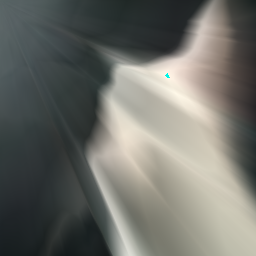

In [ ]:
relu_image = Image.fromarray(vals)
relu_image.show()

In [21]:
siren_model = siren_mlp(256,4,30).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(siren_model.parameters(), lr=0.0001)

In [22]:
siren_psnr = []

In [58]:
num_epochs = 10000
for e in tqdm(range(num_epochs)):
  y_pred_train = siren_model(torch.from_numpy(X.astype('float32')).to(device)).squeeze()
  loss = criterion(y_pred_train, torch.from_numpy(y.astype('float32')).to(device)) # loss is a tensor which stores the current value of train loss
  siren_psnr.append(20 * np.log10(1.0 / np.sqrt(loss.item())))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 1000 == 0:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss
  if e == num_epochs-1:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss

  0%|          | 6/10000 [00:00<06:29, 25.64it/s]

Epoch [0/10000], Loss: 48.1990


 10%|█         | 1006/10000 [00:30<05:12, 28.75it/s]

Epoch [1000/10000], Loss: 38.4186


 20%|██        | 2008/10000 [01:01<04:01, 33.06it/s]

Epoch [2000/10000], Loss: 30.4954


 30%|███       | 3008/10000 [01:31<03:31, 33.01it/s]

Epoch [3000/10000], Loss: 26.5073


 40%|████      | 4008/10000 [02:02<03:01, 33.08it/s]

Epoch [4000/10000], Loss: 21.6942


 50%|█████     | 5008/10000 [02:32<02:31, 32.89it/s]

Epoch [5000/10000], Loss: 17.9686


 60%|██████    | 6008/10000 [03:02<02:01, 32.87it/s]

Epoch [6000/10000], Loss: 14.9070


 70%|███████   | 7008/10000 [03:33<01:30, 33.02it/s]

Epoch [7000/10000], Loss: 12.0461


 80%|████████  | 8008/10000 [04:03<01:00, 33.08it/s]

Epoch [8000/10000], Loss: 10.0195


 90%|█████████ | 9008/10000 [04:33<00:30, 32.91it/s]

Epoch [9000/10000], Loss: 8.9888


100%|██████████| 10000/10000 [05:03<00:00, 32.91it/s]

Epoch [9999/10000], Loss: 7.7082


In [59]:
len(siren_psnr)

23000

In [60]:
y_preds = siren_model(torch.from_numpy(X.astype('float32')).to(device))

In [61]:
vals  = y_preds.cpu().detach().numpy().reshape(256,256,3).astype('uint8')

In [62]:
vals.shape

(256, 256, 3)

In [63]:
vals

array([[[ 91, 101,  95],
        [ 91,  98,  95],
        [ 89,  99,  97],
        ...,
        [ 40,  44,  43],
        [ 39,  44,  44],
        [ 40,  46,  46]],

       [[ 86,  99,  98],
        [ 92, 100,  97],
        [ 90,  97,  93],
        ...,
        [ 35,  43,  44],
        [ 41,  45,  44],
        [ 39,  45,  45]],

       [[ 89, 101, 102],
        [ 93, 103, 101],
        [ 90,  96,  95],
        ...,
        [ 44,  49,  46],
        [ 43,  49,  49],
        [ 40,  45,  44]],

       ...,

       [[ 22,  25,  25],
        [ 22,  25,  25],
        [ 22,  27,  27],
        ...,
        [171, 170, 159],
        [170, 167, 156],
        [172, 169, 159]],

       [[ 23,  26,  26],
        [ 21,  23,  23],
        [ 20,  24,  24],
        ...,
        [176, 177, 166],
        [170, 168, 158],
        [164, 162, 153]],

       [[ 24,  25,  25],
        [ 20,  23,  23],
        [ 19,  22,  23],
        ...,
        [175, 175, 162],
        [173, 172, 161],
        [168, 166, 155]]

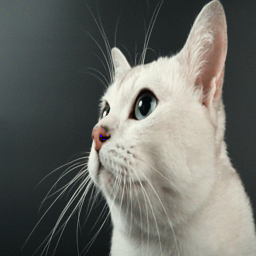

In [64]:
siren_image = Image.fromarray(vals)
siren_image.show()

In [57]:
array = np.asarray(siren_image)
array.shape

(256, 256, 3)

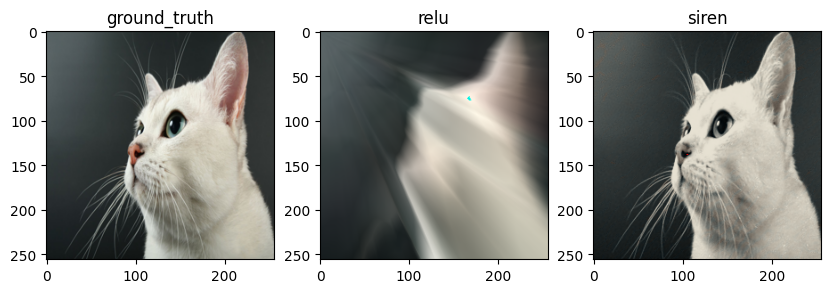

In [ ]:
fix, ax = plt.subplots(1,3, figsize = (10,5))
ax[0].imshow(img)
ax[0].set(title = 'ground_truth')
ax[1].imshow(relu_image)
ax[1].set(title = 'relu')
ax[2].imshow(siren_image)
ax[2].set(title = 'siren')
plt.show()